# Graph Algorithms & Structures 2

In [1]:
import os

if not os.path.exists("./data/graph-small"):
    os.makedirs("./data/graph-small")
    
!wget -qO "./data/graph-small/graph.gexf" "https://github.com/memgraph/graph-analytics-course/raw/master/dataset/graph-small/graph.gexf"

## Community detection

### Girvan-NewMan algorithm

The communities in a graph are discovered by iteratively removing the graph's edges based on the edge betweenness centrality value.

Algorithm steps are as follow:
1. Calculate betweenness centrality of all edges in graph.
2. Remove the edge with highest betweenness centrality.
3. Recalculate betweenness centralities and repeat the process until there are no edges left.

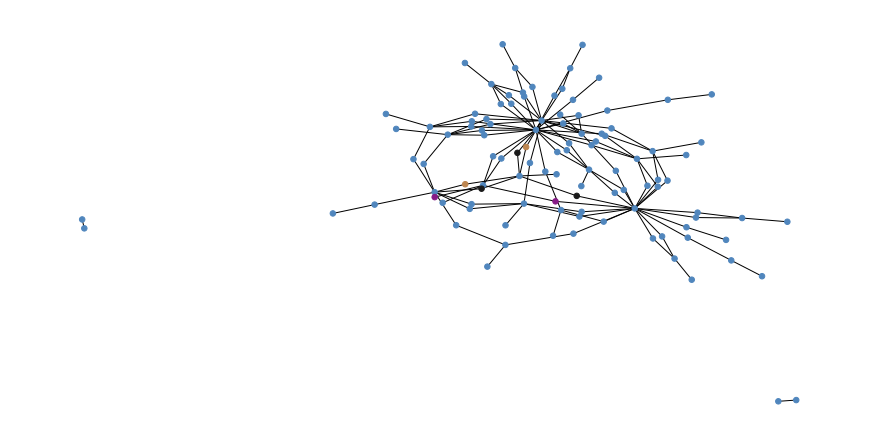

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman

# Remove social media accounts and isolates from the dataset
def remove_unnecessary_data(G):
    H = G.copy()
    for node in H.nodes(data=True):
        if node[1]['label']=='SocialMedia':
            G.remove_node(node[0])
    G.remove_nodes_from(list(nx.isolates(G)))
    return G

def get_color(i, r_off=1, g_off=1, b_off=1):
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 4) % n) / (n-1)
    g = low + span * (((i + g_off) * 8) % n) / (n-1)
    b = low + span * (((i + b_off) * 12) % n) / (n-1)
    return (r, g, b)

G = nx.read_gexf('./data/graph-small/graph.gexf')
G = G.to_undirected()
G = remove_unnecessary_data(G)
communities = girvan_newman(G)

node_groups = []
for community in next(communities):
    node_groups.append(list(community))

node_colors = []
for ng in range(len(node_groups)):
    for node in G:
        if node in node_groups[ng]:
            node_colors.append(get_color(ng))

plt.figure(figsize=(12, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=node_colors, node_size=30)
plt.show()

### Louvain modularity

The Louvain algorithm is based on the modularity measure of a graph. This means evaluating how much more densely connected the nodes are within the community compared to how connected they would be in a random graph.

Algorithm steps are as follows:
1. Assign a community to each node.
2. Create a new community with neighbouring nodes to maximise modularity.
3. Create a new weighted graph with communities from the previous step as nodes of the graph.
4. Repeat the process until the maximum possible modularity is achieved and there are no changes in the graph.

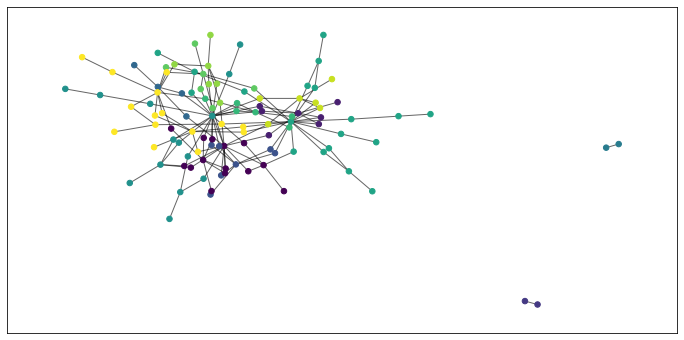

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
from community import community_louvain

# Remove social media accounts and isolates from the dataset
def remove_unnecessary_data(G):
    H = G.copy()
    for node in H.nodes(data=True):
        if node[1]['label']=='SocialMedia':
            G.remove_node(node[0])
    G.remove_nodes_from(list(nx.isolates(G)))
    return G

G = nx.read_gexf('./data/graph-small/graph.gexf')
G = G.to_undirected()
G = remove_unnecessary_data(G)
communities = community_louvain.best_partition(G)

pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(communities.values()) + 1)
plt.figure(figsize=(12, 6))
nx.draw_networkx_nodes(G, pos, communities.keys(), cmap=cmap,
    node_color=list(communities.values()), node_size=30)
nx.draw_networkx_edges(G, pos, alpha=0.6)
plt.show()

## Connectivity

A basic concept asks for the minimum number of elements that need to be removed to disconnect the graph into two or more isolated subgraphs.

In [4]:
%%bash

wget -qO "./data/graph-small/graph-components.txt" "https://github.com/memgraph/graph-analytics-course/raw/master/lecture-4/components/graph-components.txt"

### Weakly connected components

The algorithm finds sets of connected nodes in an undirected graph where all nodes in the same set form a connected component.

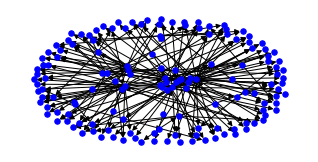

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import networkx as nx
from networkx.algorithms.components import weakly_connected_components

g = nx.read_gexf('./data/graph-small/graph.gexf')
wcc_subgraphs = [g.subgraph(wcc) for wcc in weakly_connected_components(g)]

# There are 7 weakly connected components and we are plotting the three biggest ones that
# represent customers of a specific store. They all have transaction at that POS device.
colorlist = ['r', 'g', 'b', 'y', 'c', 'm', 'k']
plt.figure(figsize=(12, 6))
for i, subgraph in enumerate(wcc_subgraphs):
    randIndex = random.randint(0, len(colorlist) - 1)
    if(len(subgraph.nodes()) > 10):
        plt.subplot(2, 2, i + 1)
        nx.draw(subgraph, node_color=colorlist[randIndex], node_size=30)
plt.show()

### Strongly connected components

A graph is said to be strongly connected if every node is reachable from every other node. A pair of nodes are said to be strongly connected to each other if there is a path in each direction between them.

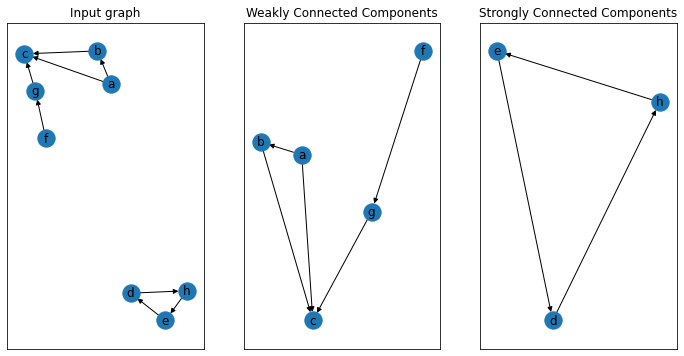

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.components import weakly_connected_components, \
    strongly_connected_components

with open('./data/graph-small/graph-components.txt') as f:
    lines = f.readlines()
    
edgeList = [line.strip().split() for line in lines]

G = nx.DiGraph()
G.add_edges_from(edgeList)

plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 3, 1)
ax.title.set_text("Input graph")
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos)

weak_components = weakly_connected_components(G)
W = [G.subgraph(c).copy() for c in weak_components]
weak_component = max(W, key=len)

ax = plt.subplot(1, 3, 2)
ax.title.set_text("Weakly Connected Components")
pos = nx.spring_layout(weak_component)
nx.draw_networkx(weak_component, pos)

strong_components = strongly_connected_components(G)
S = [G.subgraph(c).copy() for c in strong_components]
strong_component = max(S, key=len)

ax = plt.subplot(1, 3, 3)
ax.title.set_text("Strongly Connected Components")
pos = nx.spring_layout(strong_component)
nx.draw_networkx(strong_component)

plt.show()

## Flows

A **flow network** is a directed graph where each node has a capacity, and each edge receives a flow. The amount of flow on edge cannot be greater than the capacity of the edge.

In [15]:
%%bash

wget -qO './data/graph-small/graph-flow.txt' 'https://github.com/memgraph/graph-analytics-course/raw/master/lecture-4/flows/graph-flow.txt'

(5,
 {'o': {'p': 0, 'q': 3},
  'p': {'r': 2},
  'q': {'r': 1, 't': 2},
  'r': {'t': 3},
  's': {'o': 3, 'p': 2},
  't': {}})
Maximum flow value is: 5


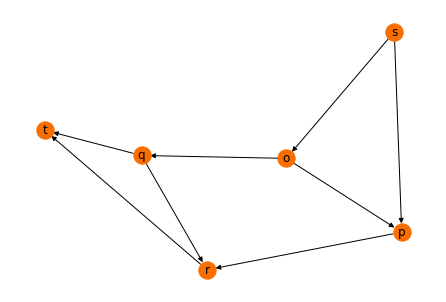

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import pprint as pp
import networkx as nx

G = nx.read_edgelist('./data/graph-small/graph-flow.txt', nodetype=str,
    data=(('capacity', int),), create_using=nx.DiGraph())
flow = nx.maximum_flow(G, _s='s', _t='t')
pp.pprint(flow)
flow_value = nx.maximum_flow_value(G, _s='s', _t='t')
print("Maximum flow value is: " + str(flow_value))

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='#f86e00')
plt.show()

## Clustering

A machine learning technique that involves the grouping of data points. Data points in the same group should share similar properties and features. In Data Science, we can use clustering algorithms to gain valuable insights from data by seeing what groups the data points fall into.

### K-means clustering

K-means is a distance-based algorithm where we calculate the distance to assign a point to a cluster.

The K-means algorithm works as follows"
1. Choose the number of clusters(*k*).
2. Select random *k* points from data to be centres.
3. Assign all the points to the closest cluster centre.
4. Recompute the centre of newly formed clusters.
5. Repeat steps 3 and 4 until centres of newly formed clusters do not change, points remain in the same clusters, or a maximum number of iterations has been achieved.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

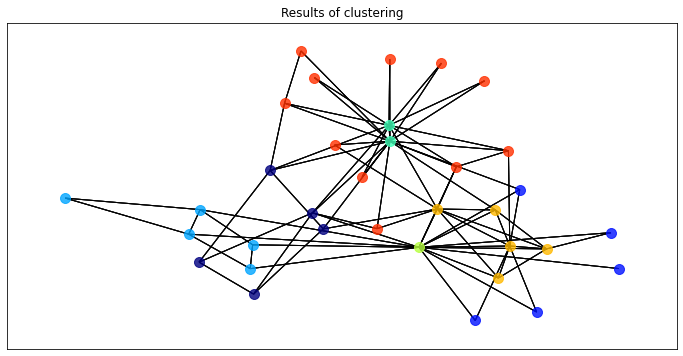

In [1]:
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import networkx as nx
import numpy as np
from collections import defaultdict
from sklearn.cluster import KMeans

def graph_to_edge_matrix(G):
    # Initialize edge matrix with zeros
    edge_matrix = np.zeros((len(G), len(G)), dtype=int)
    # Loop to set 0 or 1 (diagonal elements are set to 1)
    for node in G:
        for neighbor in G.neighbors(node):
            edge_matrix[int(node)][int(neighbor)] = 1
        edge_matrix[int(node)][int(node)] = 1
    return edge_matrix

G = nx.karate_club_graph()
# Convert a networkx graph into an edge matrix
edge_matrix = graph_to_edge_matrix(G)

# K-means clustering - this one is not very suited for our dataset
number_of_clusters = 7
model = KMeans(n_clusters=number_of_clusters, n_init=1000)
model.fit(edge_matrix)
clustering_labels = list(model.labels_)

def draw_communities(G, pos, clustering_labels):
    # Convert clustering_labels to a dict where 
    # key=cluster_id, value=list of nodes in cluster
    cluster_dict = defaultdict(list)
    for node_id, cluster_id in enumerate(clustering_labels):
        cluster_dict[cluster_id].append(node_id)
        
    # Normalize number of clusters for choosing a color
    norm = colors.Normalize(vmin=0, vmax=len(cluster_dict.keys()))
    
    for club, members in cluster_dict.items():
        nx.draw_networkx_nodes(G, pos, nodelist=members, 
            node_color=cm.jet(norm(club)), node_size=100, alpha=0.8)
        nx.draw_networkx_edges(G, pos, alpha=0.5)
        
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 6))
plt.title("Results of clustering")
# Draw the nodes to a plot with assigned colors for each individual cluster
draw_communities(G, pos, clustering_labels)
plt.show()

### Spectral clustering

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

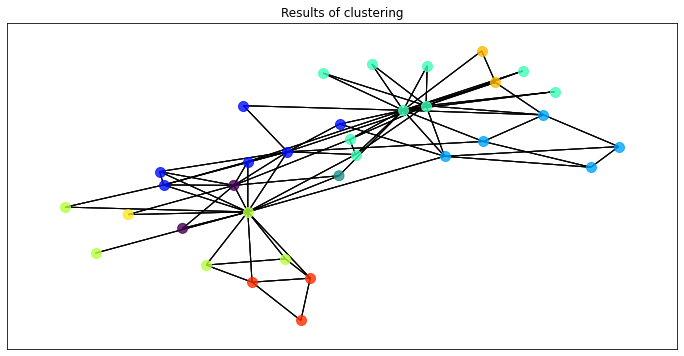

In [2]:
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import networkx as nx
import numpy as np
from collections import defaultdict
from sklearn.cluster import SpectralClustering

def graph_to_edge_matrix(G):
    # Initialize edge matrix with zeros
    edge_matrix = np.zeros((len(G), len(G)), dtype=int)
    # Loop to set 0 or 1 (diagonal elements are set to 1)
    for node in G:
        for neighbor in G.neighbors(node):
            edge_matrix[int(node)][int(neighbor)] = 1
        edge_matrix[int(node)][int(node)] = 1
    return edge_matrix

G = nx.karate_club_graph()
# Convert a networkx graph into an edge matrix
edge_matrix = graph_to_edge_matrix(G)

# Spectral clustering - this one is better suited for our MemBank dataset
number_of_clusters = 7
model = SpectralClustering(n_clusters=number_of_clusters, 
    affinity='precomputed', n_init=1000)
model.fit(edge_matrix)
clustering_labels = list(model.labels_)

def draw_communities(G, pos, clustering_labels):
    # Convert clustering_labels to a dict where 
    # key=cluster_id, value=list of nodes in cluster
    cluster_dict = defaultdict(list)
    for node_id, cluster_id in enumerate(clustering_labels):
        cluster_dict[cluster_id].append(node_id)
        
    # Normalize number of clusters for choosing a color
    norm = colors.Normalize(vmin=0, vmax=len(cluster_dict.keys()))
    
    for club, members in cluster_dict.items():
        nx.draw_networkx_nodes(G, pos, nodelist=members, 
            node_color=cm.jet(norm(club)), node_size=100, alpha=0.8)
        nx.draw_networkx_edges(G, pos, alpha=0.5)
        
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 6))
plt.title("Results of clustering")
# Draw the nodes to a plot with assigned colors for each individual cluster
draw_communities(G, pos, clustering_labels)
plt.show()

## Graph colouring

A special case of graph labelling. In its simplest form, it is a way of colouring nodes of graph so that no two adjacent nodes are of the same colour.

Graph colouring algorithm works as follows:
1. Arrange the nodes of the graph in an order.
2. Choose the first nodes and colour it the first colour.
3. Choose the next nodes and colour it with the lowest numbered colour that has not been put on any nodes adjacent to it. If all the adjacent nodes are coloured with this colour, assign a new colour.
4. Repeat step 3 until all of the nodes are coloured.

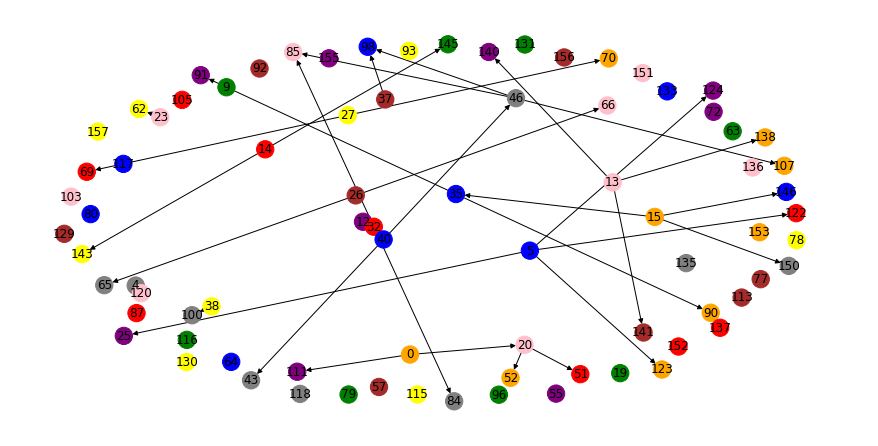

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import random

def sample_graph(G, number_of_samples, seed):
    random.seed(seed)
    H = G.copy()
    samples = random.sample(list(G.nodes()), number_of_samples)
    for n in G:
        if n not in samples:
            H.remove_node(n)
    return H

G = nx.read_gexf('./data/graph-small/graph.gexf')
# Select defined number of random nodes from a graph because
# because the complete one is too big to visualize properly
G = sample_graph(G, 80, 0)
d = nx.coloring.equitable_color(G, num_colors=9)

colors = [
    "blue", "gray", "pink",
    "red", "orange", "purple",
    "brown", "yellow", "green"
]

node_colors = []
for i in d.keys():
    node_colors.append(colors[d[i]])

plt.figure(figsize=(12, 6))
nx.draw(G, node_color=node_colors, with_labels=True)
plt.show()